In [1]:
print("hy")

hy


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
df = pd.read_csv("../data/raw/spotify_millsongdata.csv")

In [4]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [5]:
df.shape

(57650, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [7]:
# content based recommendes system

In [8]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [9]:
# top artist and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [10]:
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)

In [11]:
# Word cloud for sing lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400,background_color='white').generate(all_lyrics)

In [12]:
# word cloud to visualize the most common words in lyrics

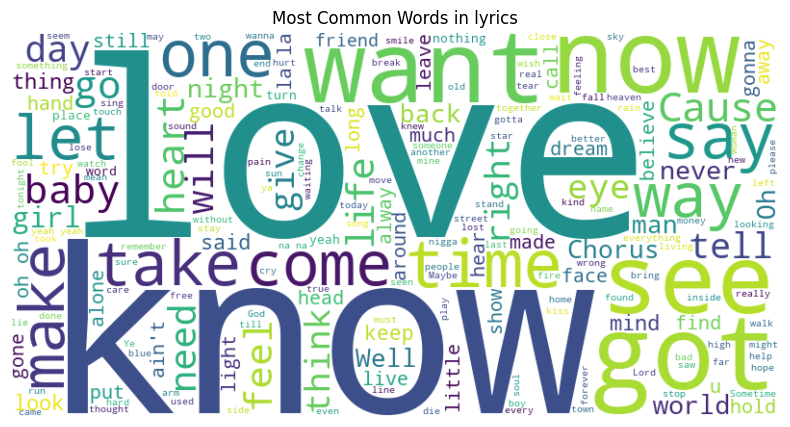

In [13]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in lyrics")
plt.show()

In [14]:
# data preprocessing

In [15]:
df.shape

(10000, 3)

In [16]:
df.head(5)

,artist,song,text
0,Rush,Subdivisions,Sprawling on the fringes of the city \r\nIn g...
1,Steely Dan,Things I Miss The Most,I don't mind the quiet \r\nOr the lonely nigh...
2,Ozzy Osbourne,Breaking All The Rules,Well I know \r\nI could be just another stran...
3,Quasi,Mammon,What was yours to give \r\nWas also yours to ...
4,Barbra Streisand,All I Know Of Love,Once I found the perfect love \r\nAnd you sho...


In [21]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    #remove special character and numbers
    text = re.sub(r"[^a-zA-Z\s]","",text)
    text = text.lower()
    # tokenize and remove stop words
    tokens = word_tokenize(text) # ["love","heart","the","is"]
    tokens  = [word for word in tokens if word not in stop_words] #["love", "heart"]
    return " ".join(tokens) # "love heart"


In [25]:
# aply preprcessing inlyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)


In [27]:
df.head()

,artist,song,text,cleaned_text
0,Rush,Subdivisions,Sprawling on the fringes of the city \r\nIn g...,sprawling fringes city geometric order insulat...
1,Steely Dan,Things I Miss The Most,I don't mind the quiet \r\nOr the lonely nigh...,dont mind quiet lonely nights dont miss funky ...
2,Ozzy Osbourne,Breaking All The Rules,Well I know \r\nI could be just another stran...,well know could another stranger guess im anot...
3,Quasi,Mammon,What was yours to give \r\nWas also yours to ...,give also sell theres haystack spin gold halo ...
4,Barbra Streisand,All I Know Of Love,Once I found the perfect love \r\nAnd you sho...,found perfect love showed everything know love...


In [ ]:
# vectorixation with tf-idf    number convert
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [28]:
# compute cosine simularity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [29]:
# recommended function
def recommended_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    #find the index of song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) ==0:
        return "Song not found in the dataset" # can be reworked to compute for songs not present in  the dataset
    idx = idx[0]

    # get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # get the song indices
    song_indices = [i[0] for i in sim_scores]

    # return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [30]:
df['song'][2]

'Breaking All The Rules'

In [32]:
# example recommandation
print("\nRecommendeation for the song 'Blinded by Rainbows:")
recommendations = recommended_songs("Things I Miss The Most") # df['song][2]
print(recommendations)


Recommendeation for the song 'Blinded by Rainbows:
                artist                 song
4240  Enrique Iglesias             Miss You
4133      Natalie Cole  Miss You Like Crazy
5682      Culture Club        Miss Me Blind
7044             Adele    Million Years Ago
1152              INXS     I Send A Message
